# 4-D-Wave Ocean SDK 入門

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/4-DWaveOceanSDK.ipynb)

D-Wave Ocean SDK(以下、Ocean) は、D-Waveマシンを使用するソフトウェアがまとまっている開発キットです。Pythonから各種機能を簡単に利用することができます。

Github: https://github.com/dwavesystems/dwave-ocean-sdk  
Document: https://docs.ocean.dwavesys.com/en/latest/

インストールするには上にある通り、pipを使用するかgithubのリポジトリをクローンします。

In [ ]:
!pip install dwave-ocean-sdk

In [ ]:
!git clone https://github.com/dwavesystems/dwave-ocean-sdk.git
!cd dwave-ocean-sdk
!python setup.py install

以降では、数分割問題を通して以下の内容について説明していきます。

- QUBOまたはイジングモデルの作り方
- Oceanの使い方
- アニーリングパラメータを変えた場合の最適化

<br>

## 定式化
D-Waveマシンに投げることができる形式は、イジングモデルとQUBOがあります。ここで詳細には触れず、Oceanを使用する上で最低限必要なことを説明します。

### QUBOとイジングモデル
QUBOの場合、2値変数$q_{i} \in \{0, 1\}$に対して、以下のハミルトニアンを考えます。

$$
H\left(\left\{q_{i}\right\}\right)= \sum_{i} Q_{i i} q_{i} + \sum_{i>j} Q_{i j} q_{i} q_{j}
$$

QUBOを解く際には、上の式の$Q_{i i}$と$Q_{i j}$を古典コンピュータで計算し、D-Waveマシンに与えることになります。  
イジングモデルの場合、2値変数$\sigma_{i} \in \{1, -1\}$に対して、以下のハミルトニアンを考えます。

$$
H\left(\left\{\sigma_{i}\right\}\right)=\sum_{i} h_{i} \sigma_{i} + \sum_{i>j} J_{i j} \sigma_{i} \sigma_{j}
$$

イジングモデルを解く際には、上の式の$h_{i}$と$J_{i j}$を古典コンピュータで計算し、D-Waveマシンに与えることになります。  QUBOとイジングモデルは、$q_{i} = (\sigma_{i} + 1) / 2$という変換式によって相互変換が可能です。  
この点において、どちらで定式化しても問題はないので、対象の問題から考えやすい方を選びましょう。  ただし、同じ問題の2種類の形式に対して、D-Waveマシンの振る舞いが異なる場合があります。

### 数分割問題
与えられた整数の集合を、2つのグループに分けることを考えます。各グループの総和が同じになるように分ける問題を、数分割問題といいます。  
例として、以下の整数の集合$C$を2つのグループに分けることを考えます。

In [3]:
# 整数の集合
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)

この場合、それぞれの総和の差がゼロになる最適解は23通り存在します (エネルギーが同じで解が違う状態があることを「縮退している」といいます)。  
例えば、$\{2,5,3,10,7\}, \{2,5,3,9,8\}$(総和は27)があります。

#### QUBO
数分割問題を最小化問題として考えると、2つのグループの総和の差を最小にすることを目指します。

<p style="text-align: center">グループAに属する数字の総和 - グループBに属する数字の総和 = 0</p>

そこで、2値変数$q_{i}$を用意し、ある数字がグループAに属する場合$q_{i} = 0$、グループBに属する場合$q_{i} = 1$とします。グループAに属する数字の総和は$\sum_{i=1}^{N}c_{i}q_{i}$、グループBに属する数字の総和は$\sum_{i=1}^{N}c_{i}(1 - q_{i})$と表されるので、先ほどの式は

$$\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)=0$$

となります。このような等式制約を素直に表現する場合、罰金法を用いることが多いです。

> (罰金法) 最小化したいコスト関数を$f(x)$、制約条件を$g(x) = 0$とすると、罰金係数$\lambda$を用いて以下の項を追加する  
> $$\min_{x} \left\{ f(x) + \lambda g(x)^2\right\}$$

したがって、数分割問題に対するQUBOは以下のようになります。

$$
H\left(\left\{\sigma_{i}\right\}\right)=\left(\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)\right)^{2}
$$

D-Waveマシンに問題を投げるために$Q_{i j}$の値を求めたいので、$H\left(\left\{\sigma_{i}\right\}\right)$を展開していきます。


$$
H\left(\left\{\sigma_{i}\right\}\right)=\left(2\sum_{i=1}^{N} c_{i} q_{i} - \sum_{i=1}^{N} c_{i} \right)^{2} =4 \sum_{i=1}^{N} c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right) q_{i}+8 \sum_{i=1}^{N} \sum_{j=i+1}^{N} c_{i} c_{j} q_{i} q_{j}+\left(\sum_{i=1}^{N} c_{i}\right)^{2}
$$

よって、

$$Q_{i i} = 4 c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right)$$
$$Q_{i j} = 8 c_{i} c_{j}$$

となります。

In [4]:
Q = {}

for i in range(N):
    Q[i, i] = 4 * C[i] * (C[i] - sum(C))
    for j in range(i + 1, N):
        Q[i, j] = 8 * C[i] * C[j]

QUBOを可視化すると以下のようになります。対角成分が$Q_{i i}$、非対角成分が$Q_{i j}$です。可視化することで、結合の度合いや係数比など対象の問題を理解しやすくなります。数分割問題については定式化の時点で明らかですが、全ての量子ビット間に相互作用が存在する、全結合の問題である事が分かります。

In [5]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

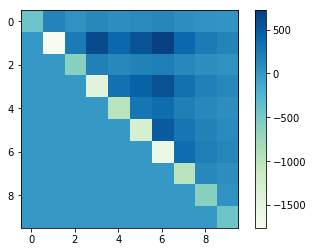

In [7]:
show_qubo(Q)

#### イジングモデル
数分割問題をイジングモデルで表すと、以下のような式で簡潔に表されます。

$$
H\left(\left\{\sigma_{i}\right\}\right) = \left(\sum_{i} c_{i} \sigma_{i}\right)^2
$$

同様に、D-Waveマシンに問題を投げるためには$h_{i}$と$J_{i j}$の値が必要です。$\sigma_{i}^2 = 1$であることに注意して、$H\left(\left{\sigma_{i}\right\}\right)$を展開していきます。

$$
H\left(\left\{\sigma_{i}\right\}\right) = \sum_{i} c_{i}^2 \sigma_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j} = \sum_{i} c_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j}
$$

よって、

$$h_{i} = 0$$

$$J_{i j} = 2 c_{i} c_{j}$$

となります。

In [8]:
h = {}
J = {}

for i in range(N):
    for j in range(i + 1, N):
        J[i, j] = 2 * C[i] * C[j]

ちなみに、Oceanの基本的なライブラリであるdimodを用いることで、イジングモデルとQUBOの相互変換が可能です。

In [9]:
import dimod

In [10]:
# イジングモデルからQUBOへの変換
model = dimod.BinaryQuadraticModel(h, J, 0.0, vartype=dimod.SPIN)
qubo, offset = model.to_qubo()

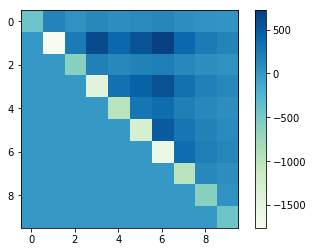

In [11]:
show_qubo(qubo)

ここまで、$Q_{i i}, Q_{i j}$や$h_{i}, J_{i j}$といった係数行列を求めるために、構成したコスト関数を展開しました。しかし、より複雑なコスト関数を扱う場合、この手計算を人間が行うのは煩わしく、計算ミスが生じる可能性があります。  
そこで、(株)リクルートコミュニケーションズが開発しているドメイン固有言語 PyQUBO を使用することで、コスト関数を展開することなくQUBOやイジングモデルを作成する事ができます。PyQUBOの使い方については、別のチュートリアルを公開しています。

Github: https://github.com/recruit-communications/pyqubo  
Document: https://pyqubo.readthedocs.io/en/latest/

OpenJijTutorial: https://github.com/OpenJij/OpenJijTutorial/blob/master/3-PyQUBO_2_OpenJij.ipynb  
Qiita: https://qiita.com/ynntech/items/fcfe7caf49f6a8eb3c53

<br>

## D-Waveマシンによる最適化
上記の数分割問題について、D-Waveマシンを用いて最適化を行います。ここでは、(1)単純に解く場合、(2)読み取り回数を変えた場合、  
(3)アニーリングタイムを変えた場合を見ていきます。

### イジングモデルを解く
D-WaveマシンのサンプラーはDWaveSampler()を使用し、さらに問題をD-Waveマシンのグラフに埋め込む場合は  
EmbeddingComposite()を使用します。

In [12]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [13]:
# ローカルに接続情報を設定している場合
sampler = EmbeddingComposite(DWaveSampler())

# 接続情報をオプションとして渡す場合
# endpoint = 'https://cloud.dwavesys.com/sapi'
# token = 'XXXXXXXXXXXXXX'
# solver = 'DW_2000Q_2_1'
# sampler = EmbeddingComposite(DWaveSampler(endpoint=endpoint, token=token, solver=solver))

In [14]:
response = {}

# イジングモデルの場合
response['default'] = sampler.sample_ising(h, J, num_reads=100)

# QUBOの場合
# response['default'] = sampler.sample_qubo(Q, num_reads=100)

ひとまず、得られた結果を確認してみましょう。解はリストとして samples_matrix に格納されています。  
このリストの大きさは、(得られた解の個数) $\times$ (量子ビット数) となっています。

In [15]:
response['default'].samples_matrix.shape

(87, 10)

上の通り、87個の解が得られました。この中に、最適解がどのくらい含まれているか見てみましょう。ここでは最適解かどうかを判別するために、それぞれの解のエネルギー値を求めます。

In [16]:
def calcurate_energy(solution, vartype='BINARY'):
    if vartype == 'BINARY':
        ene = sum(C) ** 2  # offset
        for i in range(N):
            ene += Q[i, i] * solution[i]
            for j in range(i + 1, N):
                ene += Q[i, j] * solution[i] * solution[j]
    elif vartype == 'SPIN':
        ene = sum(C[i] ** 2 for i in range(N))
        for i in range(N):
            for j in range(i + 1, N):
                ene += J[i, j] * solution[i] * solution[j]
    else:
        raise ValueError("vartype mast be 'BINARY' or 'SPIN'.")

    return ene

In [17]:
gs_indices = []
for i in range(len(response['default'].samples_matrix)):
    ene = calcurate_energy(response['default'].samples_matrix[i], vartype='SPIN')
#     print(i, response['default'].samples_matrix[i], 'Energy=', ene)
    if ene == 0:  # エネルギー値が0であれば最適解
        gs_indices.append(i)

In [18]:
print(len(gs_indices))

5


最適解が重複を含めて5個得られました。2つのグループは以下のようになっています。全く同じ解もあれば、異なる分け方があったりと、解がいくつか得られたことが分かります。

In [19]:
for i in gs_indices:
    optimal_solution = response['default'].samples_matrix[i]
    group_A = [C[i] for i, s in enumerate(optimal_solution) if s == 1]
    group_B = [C[i] for i, s in enumerate(optimal_solution) if s == -1]

    print(i, optimal_solution)
    print('Group A:', group_A, ', Sum =', sum(group_A))
    print('Group B:', group_B, ', Sum =', sum(group_B))

39 [ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A: [2, 8, 5, 7, 5] , Sum = 27
Group B: [10, 3, 9, 3, 2] , Sum = 27
41 [-1  1  1 -1 -1 -1  1 -1  1  1]
Group A: [10, 3, 9, 3, 2] , Sum = 27
Group B: [2, 8, 5, 7, 5] , Sum = 27
50 [ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A: [2, 8, 5, 7, 5] , Sum = 27
Group B: [10, 3, 9, 3, 2] , Sum = 27
57 [-1 -1  1 -1  1 -1  1  1  1  1]
Group A: [3, 5, 9, 5, 3, 2] , Sum = 27
Group B: [2, 10, 8, 7] , Sum = 27
84 [ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A: [2, 8, 5, 7, 5] , Sum = 27
Group B: [10, 3, 9, 3, 2] , Sum = 27


2つのグループの総和がいずれも等しい、最適解を得ることができました。  
また、D-Waveマシンから返される結果には、解以外にも様々な情報が含まれています (document: [SampleSet](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html#dimod.SampleSet))。

**data_vectors**
- energy: 埋め込んだD-Waveマシンのグラフにおけるエネルギー値
- num_occurrences: 解の出現頻度
- chain_break_fraction: D-Waveマシンのグラフにおいて壊れたチェーンの割合

**info**  
実行時のQPU(Quantum Processing Unit)に関する情報

In [20]:
response['default'].data_vectors

{'energy': array([-114., -174., -270., -270., -270., -114., -270., -270., -114.,
        -270., -270., -270., -270., -306., -334., -270., -306., -270.,
          30.,  786.,   30., 1230., -354., -114., -114., -334., -226.,
        -306.,  530., -334.,   30., -354., -354.,   30.,  306., -114.,
        -226., -226., -114., -370., -366., -370., -354., -354., -354.,
        -334.,   30., -270., -114., -114., -370., -114.,  306.,  114.,
          30.,  306., -174., -370., -226., -366., -270., -366., -334.,
        -114.,  530., -114.,   30., -334.,  -46., -354.,   30., -114.,
        -354., -270.,  -46., -114., -270., -354., -366.,  114., -270.,
        -226., -354., -114., -370., -270., -366.]),
 'num_occurrences': array([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
response['default'].info

{'timing': {'total_real_time': 24029,
  'qpu_access_overhead_time': 2490,
  'anneal_time_per_run': 20,
  'post_processing_overhead_time': 981,
  'qpu_sampling_time': 16396,
  'readout_time_per_run': 123,
  'qpu_delay_time_per_sample': 21,
  'qpu_anneal_time_per_sample': 20,
  'total_post_processing_time': 981,
  'qpu_programming_time': 7633,
  'run_time_chip': 16396,
  'qpu_access_time': 24029,
  'qpu_readout_time_per_sample': 123}}

### 読み取り回数を変えてみる
次に、読み取り回数を変えた場合に得られる解がどのように変わるかを見てみましょう。  
sample_ising()、またはsample_qubo()のnum_readsに値を設定することで、読み取り回数を指定できます。  
num_readsのデフォルト値は1で、先ほどは100回で実行しました。今度は、1000回で行なってみましょう。

In [22]:
# イジングモデルの場合
response['num_reads'] = sampler.sample_ising(h, J, num_reads=1000)

# QUBOの場合
# response['num_reads'] = sampler.sample_qubo(Q, num_reads=1000)

In [23]:
response['num_reads'].samples_matrix.shape

(675, 10)

In [24]:
gs_indices = []
for i in range(len(response['num_reads'].samples_matrix)):
    ene = calcurate_energy(response['num_reads'].samples_matrix[i], vartype='SPIN')
#     print(i, response['default'].samples_matrix[i], 'Energy=', ene)
    if ene == 0:  # エネルギー値が0であれば最適解
        gs_indices.append(i)

In [25]:
len(gs_indices)

44

単純ですが読み取り回数を増やすことで、得られた最適解の個数が増加しました。一方で、アニーリングタイム(1回のアニーリングに要する時間)が 20$\mu s$ (デフォルト値)と短く、読み取り回数を増加させても実時間ではそれほど差はありません。

In [26]:
response['num_reads'].info

{'timing': {'total_real_time': 171559,
  'qpu_access_overhead_time': 1277,
  'anneal_time_per_run': 20,
  'post_processing_overhead_time': 691,
  'qpu_sampling_time': 163960,
  'readout_time_per_run': 123,
  'qpu_delay_time_per_sample': 21,
  'qpu_anneal_time_per_sample': 20,
  'total_post_processing_time': 691,
  'qpu_programming_time': 7599,
  'run_time_chip': 163960,
  'qpu_access_time': 171559,
  'qpu_readout_time_per_sample': 123}}

### アニーリングタイムを変えてみる
最後に、アニーリングタイムを変えた場合に得られる解がどのように変わるかを見てみましょう。
sample_ising()、またはsample_qubo()のannealing_timeに値を設定することで、アニーリングタイムを指定できます。  先ほどは、デフォルト値の 20$\mu s$ で実行しました。今度は、100$\mu s$ でアニーリングを行なってみましょう。

In [27]:
# イジングモデルの場合
response['annealing_time'] = sampler.sample_ising(h, J, num_reads=100, annealing_time=50)

# QUBOの場合
# response['annealing_time'] = sampler.sample_qubo(Q, num_reads=100, annealing_time=100)

In [28]:
response['annealing_time'].samples_matrix.shape

(97, 10)

In [29]:
gs_indices = []
for i in range(len(response['annealing_time'].samples_matrix)):
    ene = calcurate_energy(response['annealing_time'].samples_matrix[i], vartype='SPIN')
#     print(i, response['default'].samples_matrix[i], 'Energy=', ene)
    if ene == 0:  # エネルギー値が0であれば最適解
        gs_indices.append(i)

In [30]:
len(gs_indices)

3

アニーリングタイムを変えたことで、得られた解に何か違いがないか調べてみます。ここでは、解のエネルギーのヒストグラムを見てみましょう。

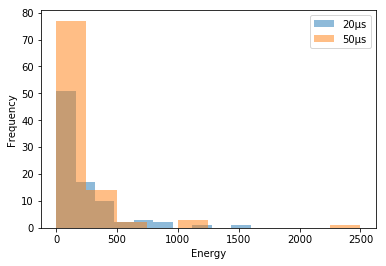

In [37]:
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in response['default'].samples_matrix], alpha=0.5, label='20μs')
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in response['annealing_time'].samples_matrix], alpha=0.5, label='50μs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

上のヒストグラムから、アニーリングタイムを増加させたことで得られた最適解の個数は減少しましたが、低いエネルギーの解を多く見つけていることが分かります。ただし、アニーリングタイムを大きくすればいいという単純な話ではありません。アニーリングタイムが小さい場合の方が最適化がうまくいくこともあり、それぞれの問題に依ります。  
また、量子アニーリングをはじめとするアニーリング法はメタヒューリスティックスなアルゴリズムであるため、実行するたびに得られる結果は異なることも注意しなければなりません。

<br>

## まとめ
数分割問題の最適化を通して、Oceanの使い方を紹介しました。このチュートリアルで説明したことを押さえるだけでも、様々なことができるようになります。例えば、以下のことを調べられるでしょう。
- 読み取り回数、アニーリングタイムに対する成功確率(最適解が得られる割合)
- 読み取り回数、アニーリングタイムに対するエネルギー値
- 複数の最適解が存在する数分割問題に対して、得られる最適解の割合

2019年4月現在、1ヶ月1分間無料でD-Waveマシンを利用することができます。ぜひ利用して、上の項目について実験してみてください。

D-Wave Leap: https://cloud.dwavesys.com/leap/

このチュートリアルでは触れることができませんでしたが、他にもアニーリングパラメータが存在します。例えば、アニーリングのスケジュールを指定することで、リバースアニーリングなど通常のアニーリングとは異なる手法を実行することができます。気になった方は、D-Waveのドキュメントを読んでみてください。